## Gaussian Mixture Model

### Two-Dimensional Data
A Gaussian mixture model (GMM) $\hat{p}$ approximates the ground-truth pdf $p^*$ by taking a weighted sum of $C$ *components*, $
\mathcal{N}(\mu_c, \Sigma_c)$, $c=1,...,C$. $C$ is a hyperparameter to be determined by outside knowledge or some sort of tuning. Splitting the training set into a training and validation set (or applying K-fold cross-validation) would be most appropriate in general to choose a single model, but we wished to see the test performance for a range of $C$ to understand its effect. Additionally, a GMM requires some sort of initialisation to then begin its training. We implemented two methods:
- Random initialisation: the initial means are a randomly chosen set of training points, and the initial covariance matrices are all the empirical covariance of the training data multiplied by a normalisation factor chosen through trial and error on the training set that seemed to lead to convergence
- K-means++: We first run a K-means++ clustering method on $C$ components, and then take the cluster centers as the initial means, and the within-cluster empirical variances as the initial variances.

However, we found that the random initialisation method was very unstable, often diverging (in particular for high numbers of components and low numbers of samples). We decided to only display results for the kmeans++ initialisation.
A number of training iterations must also be selected, an appropriate method would be to set a high number and then set some termination criterion to check for convergence (in particular that the means and variances stop changing significantly); for simplicity we chose 30 (running sklearn.mixture implementation of the GMM, convergence seemed to occur before 30, so we looked up the answer a little bit in this sense. A better implementation could be preferable)

We define some functions to aid in model training and then obtain some GMMs fitted to the training set for some chosen numbers of components (C), each initialisation method (random or K-means++), and training set size. We simulate having a data set of size $n=100, 200, 500$ and then splitting these 80/20 into training and test sets.

Code comments:
More vectorisation or better yet, implementation in pytorch, would yield much quicker calculations, but given that all models are created in ~1 min on my old laptop, we found this implementation sufficiently fast.

For now, we obtain negative MMD_squared results, I'm going to discuss this with Professor Koethe since this seems undesirable, but also possible within the definitions provided in the lectures

In [1]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.stats import multivariate_normal
from utils import get_train_test_data
from MMD import calculate_mmd
from itertools import product
from collections import namedtuple
from tqdm.auto import tqdm

# Define helper functions for gmm
def random_initialisation(train_data, C, cov_normalisation=0.2, seed=None):
    if seed:
        np.random.seed(seed)
    # Weights are uniform
    weights_array = np.ones(C) * 1 / C

    # Select C data points to act as initial means
    data_indices = np.random.choice(len(train_data), C, replace=False)
    means_array = train_data[data_indices]

    # Take empirical covariance and multiply by a normalisation factor for random covariances
    data_empirical_covariance = np.cov(train_data, rowvar=False)
    covariances_array = np.repeat(data_empirical_covariance[np.newaxis], C,
                                  axis=0) * cov_normalisation

    return weights_array, means_array, covariances_array

def kmeans_initialisation(train_data, C, seed):
    # Weights are uniform
    weights_array = np.ones(C) * 1 / C

    # Perform k means clustering; initial means are cluster centers, initial variances are cluster empirical variances
    kmeans = KMeans(n_clusters=C, init='k-means++', random_state=seed).fit(train_data)

    ## Obtain means
    means_array = kmeans.cluster_centers_

    ## Obtain covariance arrays by getting empirical covariance within each
    covariances_array = np.zeros((C, 2, 2))
    for k in range(C):
        cluster_data = train_data[kmeans.labels_ == k]
        deviations = cluster_data - means_array[k]
        covariances_array[k] = np.cov(deviations, rowvar=False)

    return weights_array, means_array, covariances_array

def get_influence_array(means_array, covariances_array, weights_array, train_data, C):
    # Store component and full distributions for getting the influence array
    component_dists = [multivariate_normal(means_array[i], covariances_array[i]) for i in range(C)]

    # define pdf_values: element i,k is the probability density of datapoint i in component k
    pdf_values = np.array([[dist.pdf(data_point) for dist in component_dists] for data_point in train_data])

    # Define gamma array: gamma_i,k = 'influences of component k on instance i'
    influence_array = weights_array * pdf_values / np.sum(weights_array * pdf_values, axis=1, keepdims=True)

    return influence_array

def single_value_pdf(x, means_array, covariances_array, weights_array):
    component_dists = [multivariate_normal(means_array[i], covariances_array[i]) for i in range(len(means_array))]

    component_pdf_values = np.array([dist.pdf(x) for dist in component_dists])

    pdf_value = np.sum([weight*density for weight,density in zip(weights_array, component_pdf_values)])
    return(pdf_value)

def update_parameters(train_data, influence_array, C):
    n = len(train_data)
    # Update parameters
    weights_array = np.sum(influence_array, axis = 0)/n

    means_array = np.zeros((C, 2))
    for k in range(C):
        means_array[k] = np.sum((influence_array[:, k, np.newaxis]*train_data), axis = 0)/(n*weights_array[k])

    covariances_array = np.zeros((C, 2, 2))
    for k in range(C):
        deviations = train_data - means_array[k]
        covariances_array[k] = \
            np.array([influence_array[i,k]*np.outer(deviations[i], deviations[i]) for i in range(n)]).sum(axis=0) \
            /influence_array.sum(axis = 0)[k]

    return weights_array, means_array, covariances_array

def make_gmm_pdf(weights_array, means_array, covariances_array):
    def gmm_pdf(x):
        component_dists = [multivariate_normal(means_array[i], covariances_array[i]) for i in range(len(means_array))]
        pdf_value = np.sum([weight*dist.pdf(x) for weight, dist in zip(weights_array, component_dists)])
        return pdf_value

    return gmm_pdf

def train_gmm(train_data, C, num_iter, init_method, init_covariance_normalisation = None, seed = None):
    # Get initial guesses
    assert init_method in ['random', 'kmeans++'], 'Invalid initialisation method'

    if init_method == 'random':
        weights_array, means_array, covariances_array = random_initialisation(train_data,
                                                                              C,
                                                                              init_covariance_normalisation,
                                                                              seed)
    elif init_method == 'kmeans++':
        weights_array, means_array, covariances_array = kmeans_initialisation(train_data,
                                                                              C,
                                                                              seed)

    # Iterate EM algorithm
    for t in range(num_iter):
        influence_array = get_influence_array(means_array, covariances_array, weights_array, train_data, C)

        weights_array, means_array, covariances_array = update_parameters(train_data, influence_array, C)

    return weights_array, means_array, covariances_array

def sample_from_gmm(weights_array, means_array, covariances_array, n, seed):
    if seed:
        np.random.seed(seed)

    # Choose for each sample which component to sample from
    components = np.random.choice(len(weights_array), size=n, p=weights_array)

    # Sample from the corresponding components
    samples = np.array([
        multivariate_normal(means_array[k], covariances_array[k]).rvs()
        for k in components
    ])

    return samples




/home/timat/anaconda3/envs/GNN/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Fix data parameters
ns = [int(1.25*100), int(1.25*200), int(1.25*500)] 
init_method = 'kmeans++'
Cs = [2,5,10]
seed = 11121
num_iter = 30
normalise = True

# Initialise results storage variable

GMMResult = namedtuple('GMMResult', ['n', 'C', 'w', 'm', 's', 'MMD'])
GMMResults = []

for n, C in tqdm(product(ns, Cs)):
    # Get data
    train_data, test_data = get_train_test_data(n, seed)

    # Optionally Normalise
    if normalise:
        mean = np.mean(train_data, axis = 0)
        std = np.std(train_data, axis = 0)

        train_data, test_data = (train_data - mean)/std, (test_data - mean)/std

    weights_array, means_array, covariances_array = \
        train_gmm(train_data, C, num_iter, init_method, seed=seed)

    learned_samples = sample_from_gmm(weights_array, means_array, covariances_array, n, seed)

    # Caclulate MMD
    gmm_mmd = calculate_mmd(test_data, learned_samples)

    GMMResults.append(GMMResult(n=n, C=C, w = weights_array, m = means_array, s = covariances_array, MMD=gmm_mmd))


for res in GMMResults:
    print(f'number of training samples: {int(0.8*res.n)}, number of components: {res.C}, MMD: {res.MMD}')

9it [01:26,  9.64s/it]

number of training samples: 100, number of components: 2, MMD: -0.019709827316906292
number of training samples: 100, number of components: 5, MMD: -0.011785981860885197
number of training samples: 100, number of components: 10, MMD: -0.011973389014051095
number of training samples: 200, number of components: 2, MMD: 0.021480313776009563
number of training samples: 200, number of components: 5, MMD: 0.005351196633576194
number of training samples: 200, number of components: 10, MMD: 0.015426215483562045
number of training samples: 500, number of components: 2, MMD: 0.017240576994951906
number of training samples: 500, number of components: 5, MMD: 0.00043184853539346424
number of training samples: 500, number of components: 10, MMD: -0.003452288269426562


### Plotting
Define a couple helper functions and variables

In [3]:
import matplotlib.pyplot as plt

# For density plots
def get_grid(train_data, pdf_func):
    # Define grid over the data range for contour plot
    x_min, x_max = train_data[:, 0].min() - 1, train_data[:, 0].max() + 1
    y_min, y_max = train_data[:, 1].min() - 1, train_data[:, 1].max() + 1
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Calculate PDF values over the grid for the contour plot
    pdf_values = np.array([
        pdf_func(np.array([x, y]))
        for x, y in zip(np.ravel(x_grid), np.ravel(y_grid))
    ])
    pdf_values = pdf_values.reshape(x_grid.shape)

    return x_grid, y_grid, pdf_values

def plot_density(x_grid, y_grid, pdf_values, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.contourf(x_grid, y_grid, pdf_values, levels=10, cmap="viridis", alpha=0.7)
    plt.colorbar(label="PDF Value")
    plt.scatter(mean[0], mean[1], color="red", marker="x", s=100, label="Mean")
    plt.scatter(train_data[:, 0], train_data[:, 1], color="blue", s=10, alpha=0.5, label="Training Data")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()

best_ind = np.argmin([res.MMD for res in GMMResults])
best_res = GMMResults[best_ind]
best_pdf = make_gmm_pdf(best_res.w, best_res.m, best_res.s)

worst_ind = np.argmax([res.MMD for res in GMMResults])
worst_res = GMMResults[worst_ind]
worst_pdf = make_gmm_pdf(worst_res.w, worst_res.m, worst_res.s)

## For plotting synthetic data
def plot_generated_data(generated_data):
    plt.subplot(1, 2, 2)
    plt.scatter(generated_data[:, 0], generated_data[:, 1], color="purple", s=10, label="Generated Data")
    plt.scatter(train_data[:, 0], train_data[:, 1], color="blue", s=10, alpha=0.5, label="Training Data")
    plt.title("Generated Data from Single Gaussian Model")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Plot (i): Density as a contour plot


We plot the pdfs of the highest MMD model as well as lowest MMD model as contour plots. Interestingly, they're both mixture models with two components, and the version with more samples performed worse (counter-intuitvely), perhaps due to some bad initialisation that led to a poor local optimum. One might have expected that allowing for more components would yield better results, which didn't occur here; I expect that over fitting may occur. We chose to allow each component to have it's own independent covariance matrix; perhaps restricting the number of parameters by setting constraints on the covariance matrices could yield better results for more components, but given the options I wouldn't expect so (eg for a spherical requirement: I don't see the pdf being well approximated by spherical Gaussians) Both plots do seem to have intuitive locations to place some mixture models; a $C=4$ model could also be trained to see if it would approximate the two arms of each moon.

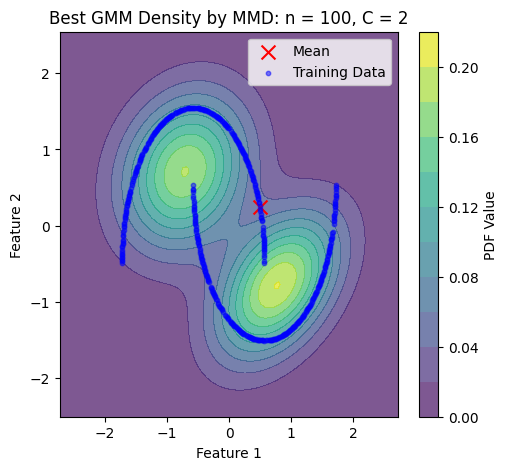

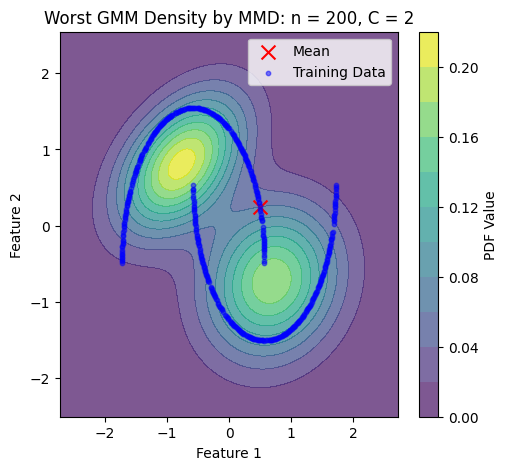

In [4]:
best_grids = get_grid(train_data, pdf_func = best_pdf)
worst_grids = get_grid(train_data, pdf_func = worst_pdf)

plot_density(*best_grids, title = f'Best GMM Density by MMD: n = {int(0.8*best_res.n)}, C = {best_res.C}')
plot_density(*worst_grids, title = f'Worst GMM Density by MMD: n = {int(0.8*worst_res.n)}, C = {worst_res.C}')

### Plot (ii): Synthetic data

We can see that the synthetic data is very unconvincing, aligning with the pdf plot above.

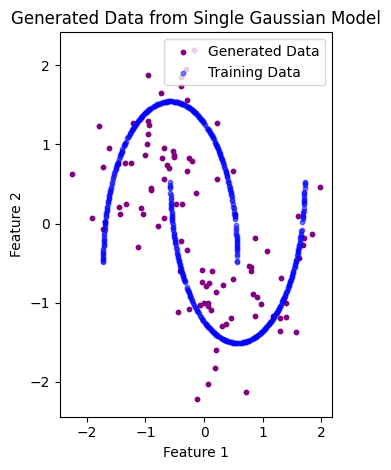

In [5]:
generated_data = sample_from_gmm(best_res.w, best_res.m, best_res.s, n = 100, seed = seed)
plot_generated_data(generated_data)

## Discussion

### Strengths
The model has much more flexibility than a single Gaussian, while remaining easy to understand, to fit, and to sample from.

### Weaknesses
- The EM algorithm can be highly sensitive to its initial paramters, so that initial parameter quality may be more important than the size/quality of the training set (depending on the complexity of the underlying distribution). This is not fully addressed by initialising with kmeans++ as seen in this very example. 
- The number of components needs to be chosen based on expert knowledge, from running pilot experiments, or from hyper-parameter tuning, all of which have their drawbacks.
- The model still struggles to fit complex distributions well, at least when the number of mixture components is small.

# Higher dimension:

(We trained allowing each component without setting further constraints on the covariance matrices to match the two-dimensional case). Training across a grid of components, we get the following MMDs: 

In [6]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

def get_digits_train_test_data(seed = None):
    if seed:
        np.random.seed(seed)
    digits_data = datasets.load_digits()
    features, targets = digits_data['data'], digits_data['target']
    
    # Split into train/test. Take random 80/20 split
    n = len(targets)
    shuffled_indices = np.random.permutation(n)
    features, targets = features[shuffled_indices], targets[shuffled_indices]
    
    split_index = np.floor(0.8*n).astype(int)
    
    train_features, test_features = features[:split_index], features[split_index:]
    train_targets, test_targets = targets[:split_index], targets[split_index]
    
    return train_features, train_targets, test_features, test_targets

def plot_digits(digit_imgs):
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))

    titles = ["Best model sampled synthetic 0", "Best model sampled synthetic 1", "Best model sampled synthetic 2",
            "Worst model sampled synthetic 0", "Worst model sampled synthetic 1", "Worst model sampled synthetic 2"]

    # Plot each image in the respective subplot with titles
    for i, ax in enumerate(axs.flat):
        ax.imshow(digit_imgs[i], cmap='gray')  # Display image in grayscale
        ax.set_title(titles[i])            # Set title
        ax.axis('off')                     # Hide axes for cleaner look

    # Adjust layout for readability
    plt.tight_layout()
    plt.show()


# Get data
train_features, train_targets, test_features, test_targets = get_digits_train_test_data(11121)
# Train gmm
## Fix hyperparams

gmms = {}
mmds = {}
synthetic_data_dict = {}
for C in [2,3,5,10,20]:
    seed = 11121

    ## Split per digit
    digit_gmms = []
    for digit in range(10):
        digit_features = train_features[train_targets == digit]

        digit_gmm = GaussianMixture(C, covariance_type='full', random_state=seed)
        digit_gmm.fit(digit_features)

        digit_gmms.append(digit_gmm)

    # Generate synthetic data: 10 cases per digit
    synthetic_features = np.array([digit_gmm.sample(10)[0] for digit_gmm in digit_gmms])
    synthetic_features = synthetic_features.reshape(-1, synthetic_features.shape[-1])
    synthetic_targets = np.repeat(np.arange(10),10)

    # Get MMD
    mmd = calculate_mmd(test_features, synthetic_features)
    
    mmds[C] = mmd
    gmms[C] = digit_gmms
    synthetic_data_dict[C] = (synthetic_features, synthetic_targets)

for C, mmd in mmds.items():
    print(f'Number of components: {C}, mmd: {mmd}')

Number of components: 2, mmd: 6.373292752000865e-06
Number of components: 3, mmd: 9.984238341473502e-07
Number of components: 5, mmd: 8.132523270268583e-06
Number of components: 10, mmd: 4.444816468106598e-06
Number of components: 20, mmd: 8.950673771105939e-06


We can see that the MMD is very small for all models and that interestingly the best result is once again attained with a small number of components. I would not have expected 2 components to have such a low mmd for what I would expect to be a very complex distribution. The same comment about overfitting applies. We will now visualise some synthetic data from the worst and best performing model, but given the low MMD, we can expect these to be pretty good. Indeed, all digits are quite recognisable.

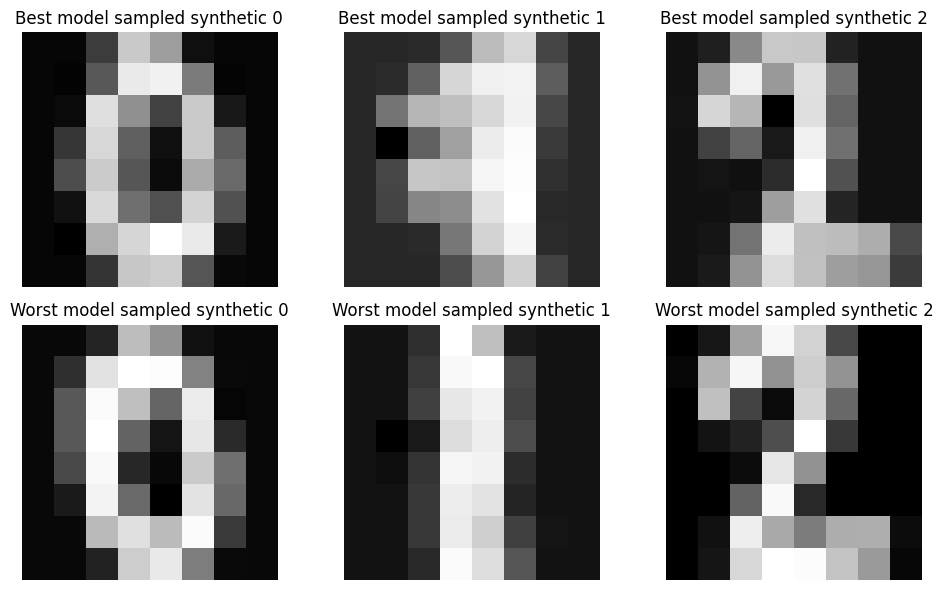

In [7]:
best_C = min(mmds, key=mmds.get)
worst_C = max(mmds, key=mmds.get)
best_gmm = gmms[best_C]
worst_gmm = gmms[worst_C]

good_digits = [best_gmm[i].sample(1)[0].reshape(8,8) for i in range(3)] # Obtain digit sample for i in range 3 and sample 1 point
bad_digits = [worst_gmm[i].sample(1)[0].reshape(8,8) for i in range(3)]
plot_digits(good_digits+bad_digits)

### Random forest
We now train a random forest on the training split of the digits dataset to classify the images into their respective digit classes, and apply it to the synthetic data to see if it can recognise the synthetic data as what it's "supposed to be". Amazingly, only digit out of 100 is falsely recognised, giving a quantitative verification of the expectation we could have from the qualitative visualisations.

In [8]:
# Get best synthetic data again
synthetic_features, synthetic_targets = synthetic_data_dict[best_C]
# Train random (forest classifier) 
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(random_state=seed)
randomForest.fit(train_features, train_targets)
rf_predictions = randomForest.predict(synthetic_features)

np.sum(synthetic_targets!=rf_predictions)
# Every digit is recognisable! 
print(f"The number of falsely classified digits is: {np.sum(synthetic_targets!=rf_predictions)}")

The number of falsely classified digits is: 1
